In [13]:
# !pip install keras-cv tensorflow;

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import numpy as np
import matplotlib.pyplot as plt
# from yolov4.tf import YOLOv4  # Assume you have a TensorFlow implementation
import h5py
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import seaborn as sns
import keras_cv

tf.config.optimizer.set_experimental_options({"cudnn_deterministic": True})

seed = 42
# Set seed for TensorFlow
# tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)

# Check Available GPUs
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 0


In [2]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive/My Drive/NAML_project/

In [3]:
# input_dataset_filepath = "../input/mel-spectogram/mel_spectrograms_v2.h5"   # for Kaggle
input_dataset_filepath = "../../00data/mel_spectrograms_v2.h5"   # for Colab

with h5py.File(input_dataset_filepath, "r") as f:
    X = f["images"][:]
    labels = f["labels"][:]

labels_map = {
    0: 'blues',
    1: 'classical',
    2: 'country',
    3: 'disco',
    4: 'hiphop',
    5: 'jazz',
    6: 'metal',
    7: 'pop',
    8: 'reggae',
    9: 'rock'
}


(1000, 640, 640, 3) (1000,)


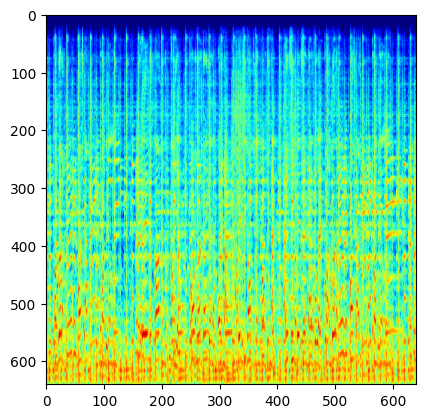

class 0: # 100 samples
class 1: # 100 samples
class 2: # 100 samples
class 3: # 100 samples
class 4: # 100 samples
class 5: # 100 samples
class 6: # 100 samples
class 7: # 100 samples
class 8: # 100 samples


In [4]:
print(X.shape, labels.shape)
input_shape = X.shape[1:]

plt.imshow(X[0])
plt.show()
for i in range(9):
    print(f'class {i}: # {labels[labels==i].shape[0]} samples')

In [5]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
X_val, X_test, y_val, y_test = train_test_split(
    X, labels, test_size=100, random_state=seed
)
X_train, X_val, y_train, y_val = train_test_split(
    X_val, y_val, test_size=100, random_state=seed
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {X_train.shape}")
print('\t', y_train.shape)
print(f"Validation: {X_val.shape}")
print('\t', y_val.shape)
print(f"Test: {X_test.shape}")
print('\t', y_test.shape)

Splitting data...
Data splitted!

Number of images:
Train: (800, 640, 640, 3)
	 (800,)
Validation: (100, 640, 640, 3)
	 (100,)
Test: (100, 640, 640, 3)
	 (100,)


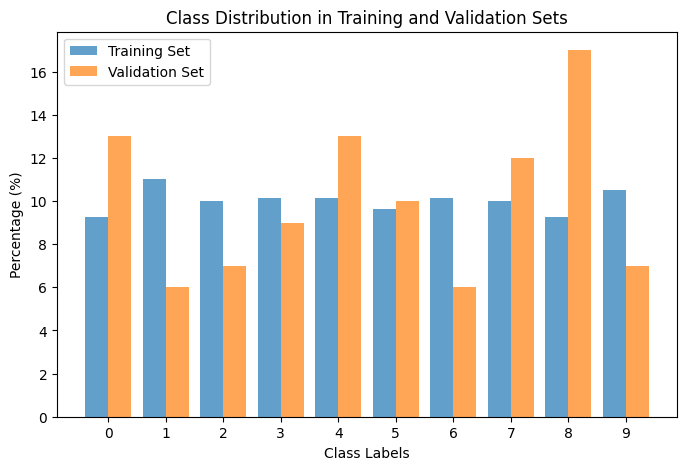

In [6]:
from collections import Counter

# Count occurrences of each class
train_counts = Counter(y_train)
val_counts = Counter(y_val)

# Convert to percentages
classes = sorted(set(y_train) | set(y_val))  # Unique classes
train_values = [(train_counts[c] / len(y_train)) * 100 for c in classes]
val_values = [(val_counts[c] / len(y_val)) * 100 for c in classes]

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.4
x_indexes = np.arange(len(classes))

plt.bar(x_indexes - bar_width/2, train_values, bar_width, label="Training Set", alpha=0.7)
plt.bar(x_indexes + bar_width/2, val_values, bar_width, label="Validation Set", alpha=0.7)

plt.xlabel("Class Labels")
plt.ylabel("Percentage (%)")
plt.title("Class Distribution in Training and Validation Sets")
plt.xticks(ticks=x_indexes, labels=classes)
plt.legend()
plt.show()

In [7]:
class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train )
class_weights = {i: w for i, w in enumerate(class_weights)}
print(class_weights)

# Convert labels to categorical format using one-hot encoding
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)
y_test = tfk.utils.to_categorical(y_test)

# Compare categorical label and "default" label representation
# Display the categorical label
print('Categorical label:', y_train[0])
# Display the equivalent numeric label
print('"Default" label:', np.argmax(y_train[0]))

{0: 1.0810810810810811, 1: 0.9090909090909091, 2: 1.0, 3: 0.9876543209876543, 4: 0.9876543209876543, 5: 1.0389610389610389, 6: 0.9876543209876543, 7: 1.0, 8: 1.0810810810810811, 9: 0.9523809523809523}
Categorical label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
"Default" label: 7


In [8]:
class MacroPrecision(tf.keras.metrics.Metric):
    def __init__(self, name="macro_precision", num_classes=10, **kwargs):
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.precisions = [tf.keras.metrics.Precision() for _ in range(num_classes)]

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_classes = tf.argmax(y_true, axis=1)
        y_pred_classes = tf.argmax(y_pred, axis=1)

        for i in range(self.num_classes):
            y_true_i = tf.cast(y_true_classes == i, tf.int32)
            y_pred_i = tf.cast(y_pred_classes == i, tf.int32)
            self.precisions[i].update_state(y_true_i, y_pred_i)

    def result(self):
        return tf.reduce_mean([p.result() for p in self.precisions])

    def reset_state(self):
        for p in self.precisions:
            p.reset_state()

In [14]:
# %cd /gdrive/My Drive/NAML_project/yolov8-best_val80
model = tfk.models.load_model('yolov8_with_regularization_86.41.keras', custom_objects={'MacroPrecision': MacroPrecision})

TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 640, 640, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(X_test, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# Convert predictions to class labels
pred_classes = np.argmax(predictions, axis=-1)

# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, pred_classes, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, pred_classes, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, pred_classes, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=annot, fmt='', xticklabels=list(labels_map.values()), yticklabels=list(labels_map.values()), cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

TP = np.diag(cm)
FP = np.sum(cm, axis=0) - TP
FN = np.sum(cm, axis=1) - TP
TN = np.sum(cm) - (TP + FP + FN)

print('TP', TP,'FP', FP, 'FN', FN, 'TN', TN, sep='\n')